<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

## Подготовка данных

Импортируем необходимые нам библиотеки и методы

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

Изучим датасет

In [ ]:
df = pd.read_csv('/datasets/Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Пропуски имеются лишь в столбце Tenure, около 10 процентов от общего числа записей в этом столбце. Этот столбец содержит значения о количестве лет проведенных с банком, заменить можно на медиану, среднее арифмитическое, 0 или же вообще снести их. Также в глаза бросаются некорректные наименования столбцов, этим нужно будет заняться.
Вообще разброс значений столбца Tenure крайне мал и это говорит что лучше воспользоваться медианной, но не совсем целесообразно относится к клиентам по медианне, скорее всего это клиенты, только пришедшие в банк.

In [ ]:
#df['Tenure'].value_counts()
#df['Tenure'].median(), df['Tenure'].mean()
df['Tenure']=df['Tenure'].fillna(0)

Изменим название столцов.

In [ ]:
#df.columns
df = df.rename(columns={'RowNumber':'row_number', 'CustomerId':'customer_id', 'CreditScore':'credit_score',
       'NumOfProducts':'num_of_products', 'HasCrCard':'has_cr_card',
       'IsActiveMember':'is_active_member', 'EstimatedSalary':'estimated_salary','Exited':'exited'})
df.columns = df.columns.str.lower()

In [ ]:
df.duplicated().sum() # проверка на дубликаты

0

С типами данных тоже есть загвостка, так, пол можно заменить булевым типом данных, так как у нас только два состояния, но тогда придется присвоить кому-то единицу, а кому-то нуль, а сексизм мы не уважаем, поэтому пока оставим так. Столбец Tenure лучше сделать интовым, так как там только интовые значения и храняться. Также наличие кредитный карты и активность клиента можно записать через булев тип, и целевой признак тоже имеет два состояния. Но с переводами в булев тип пока повеременим.

In [ ]:
df['tenure'] = df['tenure'].astype(int)
df['num_of_products'] = df['num_of_products'].astype(int)

Построим гистограмы по столбцам, чтобы оценить выбивающиеся значения

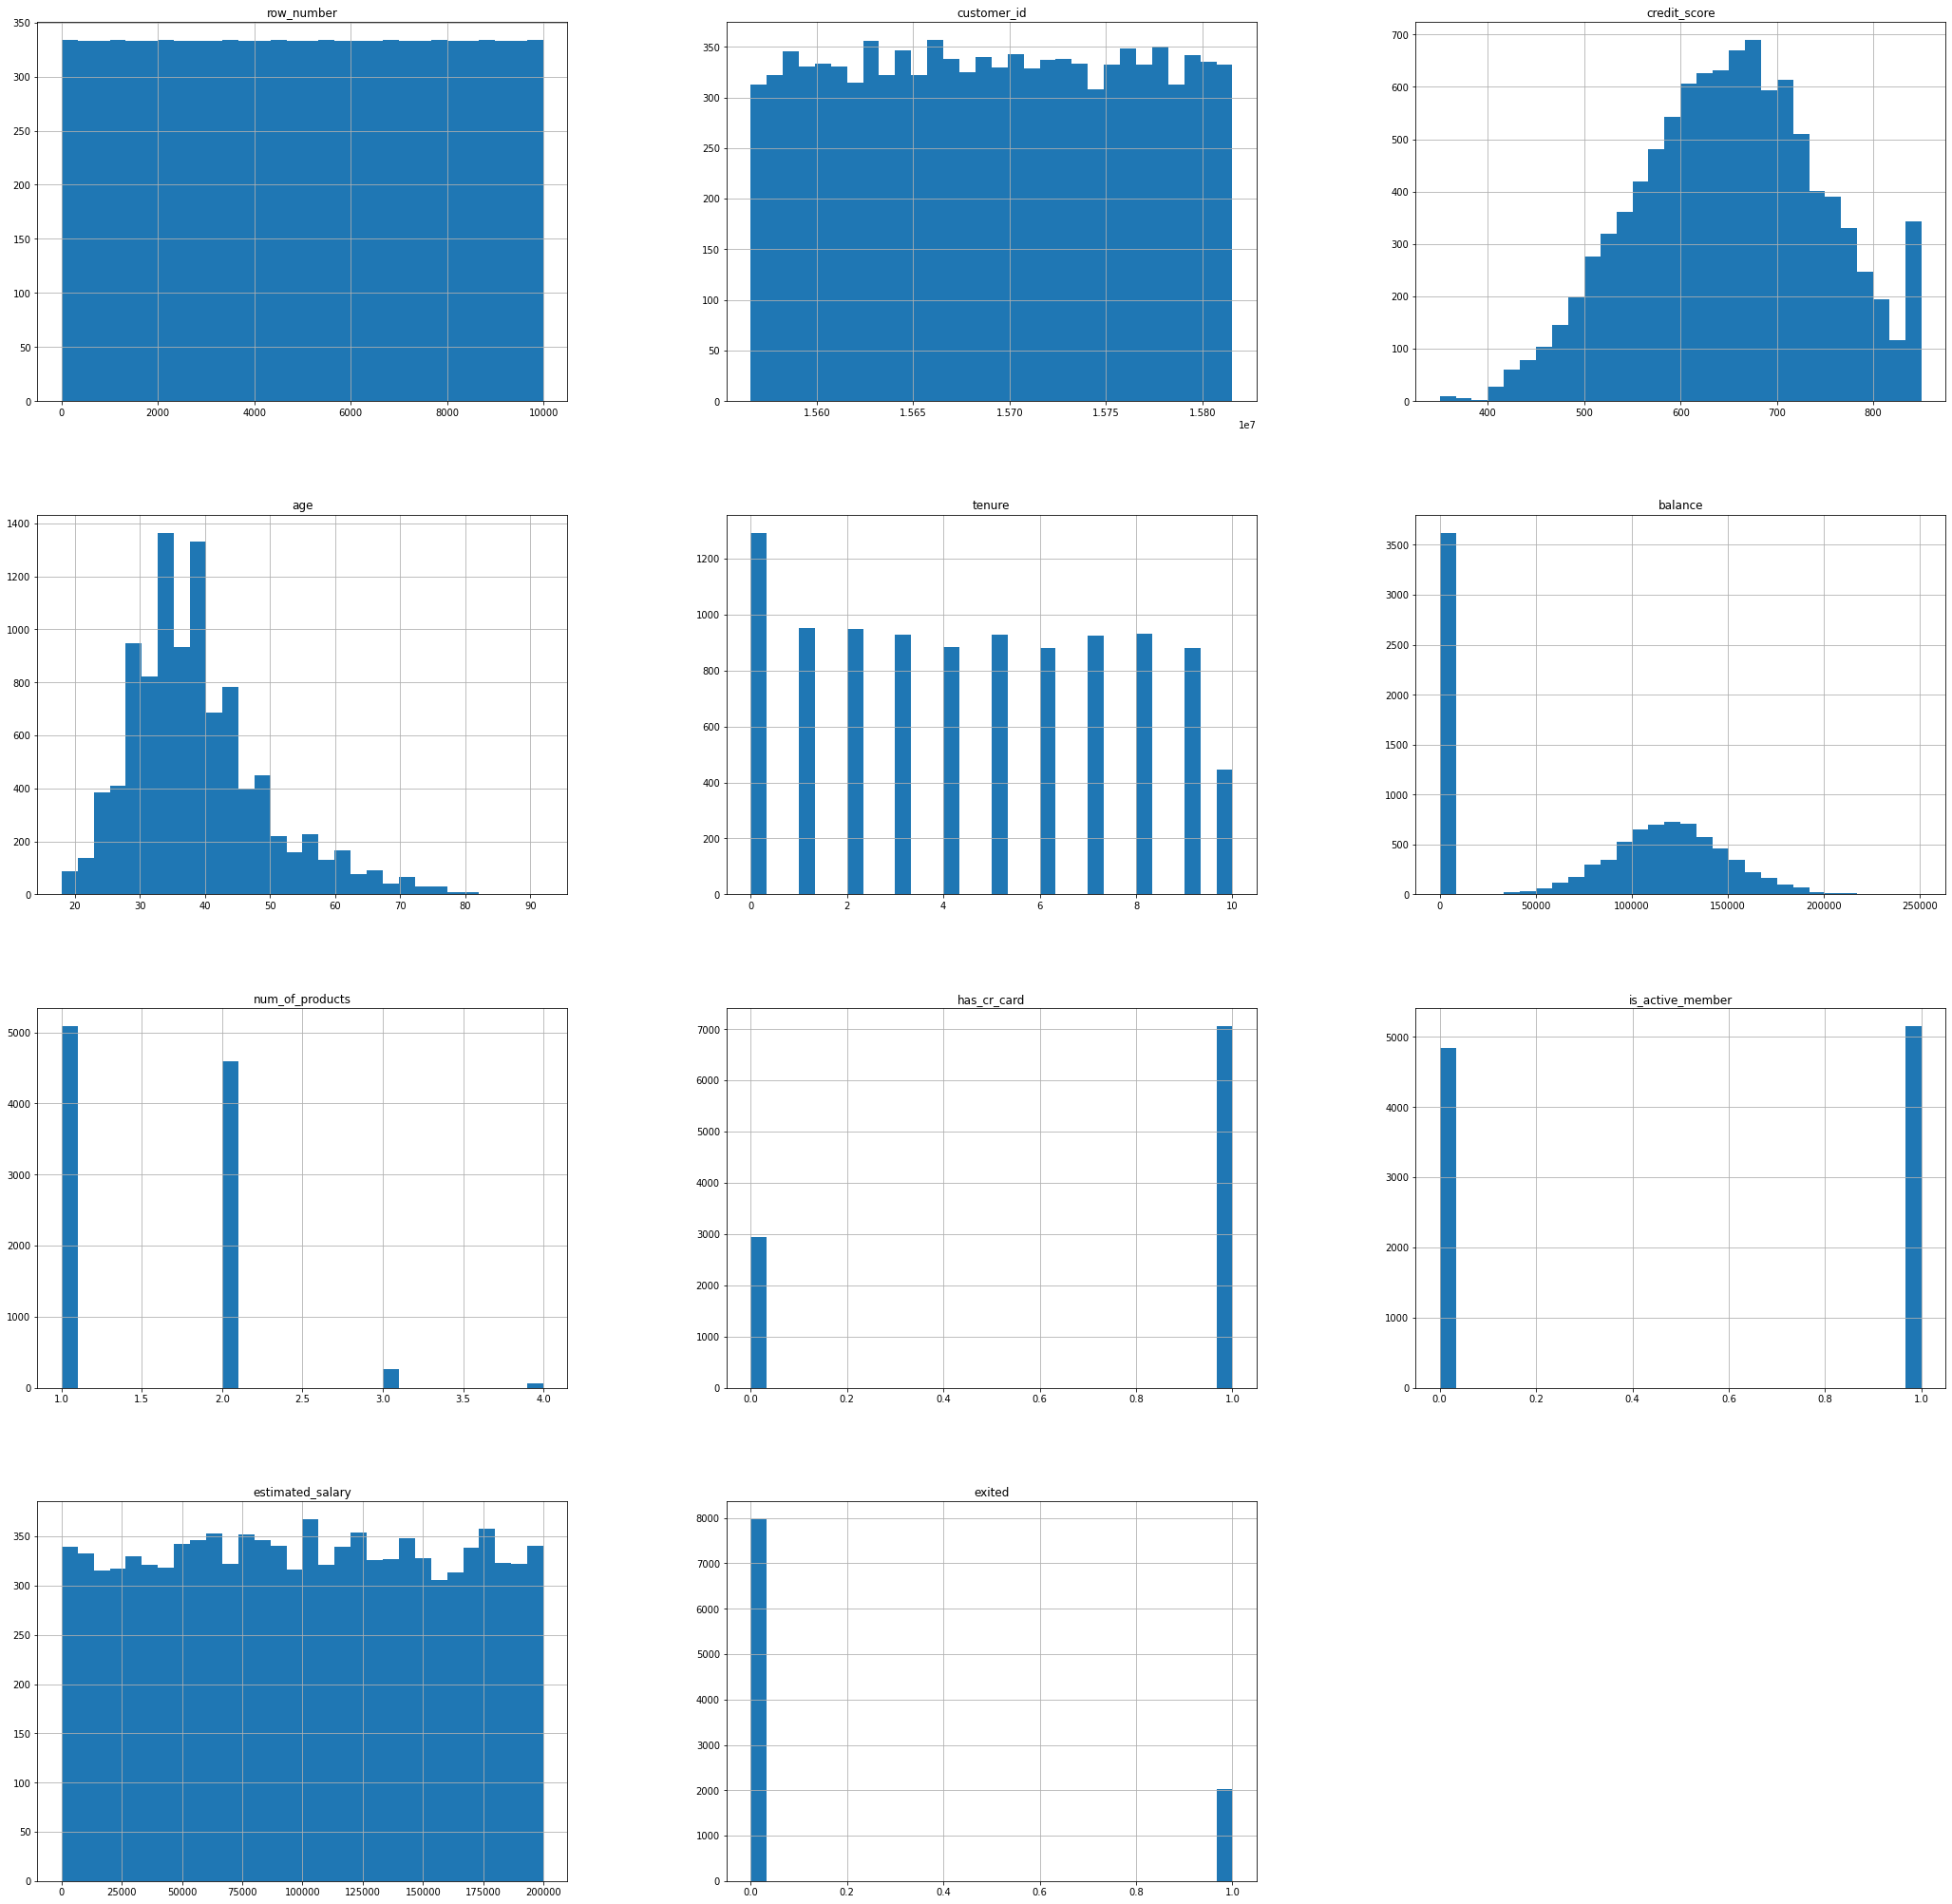

In [ ]:
df.hist(figsize=(36,36), bins=30)
plt.show()

В целом все не так плохо, несмотря на то, что мы накинули почти в 1000 записей 0 в tenure, несмотря на то, что он явно выделяется, выделяется не так ужасно. Что касаемо баланса, конечно интерсно узнать, не являются ли эти 3500 записей студентами, в остальных случаях их нулевый баланс выглядит грустно. Ну и кредит_скор немного выбивается, не уж то такой высокий кредитный рейтинг у стольких людей? Булевые столбцы так и напрашиваются на перевод к типу данных, но держу себя пока что в руках...

Также подготовим данные для машинного обучения, некоторые столбцы там не понадобятся.

In [ ]:
#Обозначим новый датафрейм "data_ml" — данные для машинного обучения
#Удалим столбцы-идентификаторы, не представляющие ценностия для алгоритма
for_drop = ['row_number','customer_id', 'surname']
df_ml = df.drop(for_drop, axis=1)
df_ml.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Данные подготовим методом OHE, что позволит нам использовать модели, деревое решений, случайный лес и логистическую регрессию.

In [ ]:
df_ml = pd.get_dummies(df_ml, drop_first=True)
df_ml.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [ ]:
df_ml.shape

(10000, 12)

В новом датафрейме мы получили 12 столбцов.
Столбец Geography содержал 3 класса, Gender_Male 2 класса — в результате мы получили только 2 и 1 столбцов соответственно, что позволяет избежать дами-ловушки.

В нашем случае нет отдельно выделенной тестовой выборки, поэтому существющие данные мы делим на три выборки:

- обучающая 60% для обучения модели
- валидационная 20% для выбора лучшего алгоритма и оптимальных параметров
- тестовая 20% для финального теста лучшей модели.

In [ ]:
features = df_ml.drop('exited', axis=1)
target = df_ml['exited']

In [ ]:
#1. Выделим валидационную 60%
features_train, features_validtest, target_train, target_validtest = train_test_split(features,
                                                    target,
                                                    train_size=0.6,
                                                    random_state=12345,
                                                    stratify=target)

In [ ]:
print('Признаки обучающей выборки:',features_train.shape,
      'Целевой признак обучающей выборки:', target_train.shape,
      'Валидационная и тестовая вместе', features_validtest.shape, target_validtest.shape)

Признаки обучающей выборки: (6000, 11) Целевой признак обучающей выборки: (6000,) Валидационная и тестовая вместе (4000, 11) (4000,)


In [ ]:
#2. Разделим оставшиеся 40% на 2 равные части (валидационная и тестовая)
features_valid, features_test, target_valid, target_test = train_test_split(features_validtest,
                                                    target_validtest,
                                                    train_size=0.5,
                                                    random_state=12345,
                                                    stratify=target_validtest)

In [ ]:
print(features_valid.shape, target_valid.shape, features_test.shape, target_test.shape)

(2000, 11) (2000,) (2000, 11) (2000,)


Полученые выбрки:
Обучающая
- features_train
- target_train

Валидационная
- features_valid
- target_valid

Тестовая
- features_test
- target_test

## Исследование задачи

Проведем масштабирование

In [ ]:
scaler = StandardScaler()
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Проверю, как часто в целевом признаке исходного датасета встречается класс «1» или «0»

In [ ]:
frequency_of_0_1 = df['exited'].value_counts(normalize=True)
frequency_of_0_1

0    0.7963
1    0.2037
Name: exited, dtype: float64

Соотношение классов примерно 1:4. Изучим модели без исправление баланса. Но на данном этапе я буду исследовать модели без учета дисбаланса классов, заведомо ожидая плохие результаты.

**Проверка на Logistic Regression**

In [ ]:
%%time

model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1', f1_score(target_valid, predicted_valid))

F1 0.30458715596330277
CPU times: user 125 ms, sys: 113 ms, total: 238 ms
Wall time: 218 ms


Показатели F1 при дисбалансе на логистической регрессии, далеки от хороших.

**Проверка на Decision Tree Classifier**

In [ ]:
%%time

best_model_tree = None
best_result = 0
accuracy_arr_tree = []

for depth in range(2, 30):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
    predicted_valid = model_tree.predict(features_valid)
    print('Max depth:', depth,'F1-score:', f1_score(target_valid, predicted_valid))
    result = f1_score(target_valid, predicted_valid)

    if best_result < result:
        best_result = result
        max_depth = depth
        best_model_tree = model_tree

print("Лучшая F-мера", best_result, 'cо значением глубины =', depth)

Max depth: 2 F1-score: 0.5203488372093023
Max depth: 3 F1-score: 0.5375722543352601
Max depth: 4 F1-score: 0.5206349206349208
Max depth: 5 F1-score: 0.5454545454545455
Max depth: 6 F1-score: 0.574468085106383
Max depth: 7 F1-score: 0.5924855491329479
Max depth: 8 F1-score: 0.5670731707317074
Max depth: 9 F1-score: 0.5588235294117648
Max depth: 10 F1-score: 0.5454545454545455
Max depth: 11 F1-score: 0.5403899721448467
Max depth: 12 F1-score: 0.5315436241610738
Max depth: 13 F1-score: 0.5326504481434059
Max depth: 14 F1-score: 0.5110565110565111
Max depth: 15 F1-score: 0.5175332527206771
Max depth: 16 F1-score: 0.5238678090575275
Max depth: 17 F1-score: 0.5108958837772397
Max depth: 18 F1-score: 0.5158264947245017
Max depth: 19 F1-score: 0.5148986889153755
Max depth: 20 F1-score: 0.5140845070422535
Max depth: 21 F1-score: 0.5017584994138335
Max depth: 22 F1-score: 0.5047169811320754
Max depth: 23 F1-score: 0.5047169811320754
Max depth: 24 F1-score: 0.5047169811320754
Max depth: 25 F1-sco

Лучший показатель при глубине 29 (max_depth 29) F1-score: 0.5924855491329479

**Проверка на Random Forest Classifier**

In [ ]:
%%time

best_model_rf = None
best_result = 0
best_depth = 0
best_est = 0

for estimator in range(10, 50, 2):
    for depth in range(10, 20):
        model_rf =  RandomForestClassifier(random_state=12345, n_estimators=estimator, max_depth = depth)
        model_rf.fit(features_train, target_train)
        predicted_valid = model_rf.predict(features_valid)
        print('N estimators:', estimator, 'Глубина:', depth, 'F1:', f1_score(target_valid, predicted_valid))
        result = f1_score(target_valid, predicted_valid)

        if result > best_result:
            best_model_rf = model_rf
            best_result = result
            best_depth = depth
            best_est = estimator

print("Лучшая F-мера", best_result, 'при глубине = {0} и количестве деревьев = {1}'.format(best_depth, best_est))

N estimators: 10 Глубина: 10 F1: 0.6
N estimators: 10 Глубина: 11 F1: 0.5907046476761619
N estimators: 10 Глубина: 12 F1: 0.5929203539823009
N estimators: 10 Глубина: 13 F1: 0.5968436154949786
N estimators: 10 Глубина: 14 F1: 0.5868613138686131
N estimators: 10 Глубина: 15 F1: 0.5899705014749261
N estimators: 10 Глубина: 16 F1: 0.6075581395348837
N estimators: 10 Глубина: 17 F1: 0.5784172661870504
N estimators: 10 Глубина: 18 F1: 0.6034985422740524
N estimators: 10 Глубина: 19 F1: 0.5837037037037037
N estimators: 12 Глубина: 10 F1: 0.6066066066066065
N estimators: 12 Глубина: 11 F1: 0.5954887218045113
N estimators: 12 Глубина: 12 F1: 0.5857988165680473
N estimators: 12 Глубина: 13 F1: 0.6078147612156295
N estimators: 12 Глубина: 14 F1: 0.5920471281296024
N estimators: 12 Глубина: 15 F1: 0.5894428152492668
N estimators: 12 Глубина: 16 F1: 0.6081871345029239
N estimators: 12 Глубина: 17 F1: 0.5655976676384838
N estimators: 12 Глубина: 18 F1: 0.6049926578560939
N estimators: 12 Глубина: 1

N estimators: 40 Глубина: 19 F1: 0.6096096096096095
N estimators: 42 Глубина: 10 F1: 0.598159509202454
N estimators: 42 Глубина: 11 F1: 0.6003016591251886
N estimators: 42 Глубина: 12 F1: 0.5923664122137404
N estimators: 42 Глубина: 13 F1: 0.5967016491754122
N estimators: 42 Глубина: 14 F1: 0.6083086053412463
N estimators: 42 Глубина: 15 F1: 0.5922619047619048
N estimators: 42 Глубина: 16 F1: 0.6033182503770739
N estimators: 42 Глубина: 17 F1: 0.6106194690265487
N estimators: 42 Глубина: 18 F1: 0.611111111111111
N estimators: 42 Глубина: 19 F1: 0.6158445440956651
N estimators: 44 Глубина: 10 F1: 0.5950920245398773
N estimators: 44 Глубина: 11 F1: 0.5981873111782477
N estimators: 44 Глубина: 12 F1: 0.5966514459665144
N estimators: 44 Глубина: 13 F1: 0.5963855421686747
N estimators: 44 Глубина: 14 F1: 0.6071428571428571
N estimators: 44 Глубина: 15 F1: 0.5991058122205662
N estimators: 44 Глубина: 16 F1: 0.6114457831325301
N estimators: 44 Глубина: 17 F1: 0.6074074074074075
N estimators: 

Лучшая F-мера 0.6184971098265896 при глубине = 18 и количестве деревьев = 18

Проведу оценку accuracy, precision и recall, а также посмотрю F-метрику.

In [ ]:
%%time

model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = DecisionTreeClassifier(random_state=12345, max_depth=best_depth)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

model = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Логистическая регрессия
Точность попадания по классам 0.8105
Precision 0.6058394160583942
Recall 0.2034313725490196
F1 0.30458715596330277

Решающее дерево
Точность попадания по классам 0.7935
Precision 0.4943820224719101
Recall 0.5392156862745098
F1 0.5158264947245017

Случайный лес
Точность попадания по классам 0.868
Precision 0.7535211267605634
Recall 0.5245098039215687
F1 0.6184971098265896

CPU times: user 320 ms, sys: 237 ms, total: 557 ms
Wall time: 570 ms


**Вывод:** Лучший результат с дисбалансом у Случайного леса с при глубине = 18 и количестве деревьев = 18

## Борьба с дисбалансом

Придадим объектам редкого класса 1 больший вес используя гиперпараметр class_weight='balanced'

**Logistic Regression**

In [ ]:
%%time

model = LogisticRegression(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()



Логистическая регрессия
Точность попадания по классам 0.7325
Precision 0.4131326949384405
Recall 0.7401960784313726
F1 0.5302897278314311

CPU times: user 96.6 ms, sys: 132 ms, total: 228 ms
Wall time: 199 ms


Действительно, F1-мера увеличилась, но показатели тяжело назвать отличными.

**Decision Tree Classifier**

In [ ]:
%%time

best_model_tree_balance = None
best_result_balance = 0

for depth in range(2, 20):
    model_tree_balance = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_tree_balance.fit(features_train, target_train)
    predicted_valid = model_tree_balance.predict(features_valid)
    print('Max depth:', depth,'F1-score:', f1_score(target_valid, predicted_valid))
    result = f1_score(target_valid, predicted_valid)

    if best_result_balance < result:
        best_result_balance = result
        max_depth = depth
        best_model_tree_balance = model_tree_balance

print("Лучшая F-мера", best_result_balance, 'cо значением глубины =', max_depth)

Max depth: 2 F1-score: 0.49801113762927607
Max depth: 3 F1-score: 0.5207100591715977
Max depth: 4 F1-score: 0.560931899641577
Max depth: 5 F1-score: 0.5546492659053834
Max depth: 6 F1-score: 0.575925925925926
Max depth: 7 F1-score: 0.5750452079566003
Max depth: 8 F1-score: 0.5494106980961015
Max depth: 9 F1-score: 0.5415860735009671
Max depth: 10 F1-score: 0.527147087857848
Max depth: 11 F1-score: 0.5228215767634855
Max depth: 12 F1-score: 0.5185950413223142
Max depth: 13 F1-score: 0.5178764897074757
Max depth: 14 F1-score: 0.517467248908297
Max depth: 15 F1-score: 0.5097142857142858
Max depth: 16 F1-score: 0.5063879210220673
Max depth: 17 F1-score: 0.5017667844522968
Max depth: 18 F1-score: 0.501775147928994
Max depth: 19 F1-score: 0.4940047961630695
Лучшая F-мера 0.575925925925926 cо значением глубины = 6
CPU times: user 489 ms, sys: 0 ns, total: 489 ms
Wall time: 500 ms


На значение f1-меры в данном случае баланс классов можно сказать не повлиял, результаты близки к предыдущим. /Лучшая F-мера 0.575925925925926 cо значением глубины = 6

**Random Forest Classifier**

In [ ]:
%%time

best_model_rf_balance = None
best_result_balance = 0
best_depth_balance = 0
best_est_balance = 0

for estimator in range(10, 50, 2):
    for depth in range(10, 20):
        model_rf_balance =  RandomForestClassifier(random_state=12345, n_estimators=estimator,
                                                   max_depth = depth, class_weight='balanced')
        model_rf_balance.fit(features_train, target_train)
        predicted_valid = model_rf_balance.predict(features_valid)
        print('N estimators:', estimator, 'Глубина:', depth, 'F1:', f1_score(target_valid, predicted_valid))
        result = f1_score(target_valid, predicted_valid)

        if result > best_result_balance:
            best_model_rf_balance = model_rf_balance
            best_result_balance = result
            best_depth_balance = depth
            best_est_balance = estimator

print("Лучшая F-мера", best_result_balance, 'при глубине = {0} и количестве деревьев = {1}'.format(best_depth_balance,
                                                                                           best_est_balance))

N estimators: 10 Глубина: 10 F1: 0.6188769414575866
N estimators: 10 Глубина: 11 F1: 0.606826801517067
N estimators: 10 Глубина: 12 F1: 0.6151866151866151
N estimators: 10 Глубина: 13 F1: 0.5991902834008096
N estimators: 10 Глубина: 14 F1: 0.601889338731444
N estimators: 10 Глубина: 15 F1: 0.5934379457917262
N estimators: 10 Глубина: 16 F1: 0.5676855895196506
N estimators: 10 Глубина: 17 F1: 0.5693430656934306
N estimators: 10 Глубина: 18 F1: 0.5376344086021505
N estimators: 10 Глубина: 19 F1: 0.5735735735735735
N estimators: 12 Глубина: 10 F1: 0.6343195266272189
N estimators: 12 Глубина: 11 F1: 0.6186868686868687
N estimators: 12 Глубина: 12 F1: 0.6119791666666665
N estimators: 12 Глубина: 13 F1: 0.5948158253751706
N estimators: 12 Глубина: 14 F1: 0.6051560379918589
N estimators: 12 Глубина: 15 F1: 0.5951359084406294
N estimators: 12 Глубина: 16 F1: 0.5805515239477504
N estimators: 12 Глубина: 17 F1: 0.5701754385964912
N estimators: 12 Глубина: 18 F1: 0.5504587155963303
N estimators: 

N estimators: 40 Глубина: 18 F1: 0.5818181818181817
N estimators: 40 Глубина: 19 F1: 0.5869894099848714
N estimators: 42 Глубина: 10 F1: 0.6329723225030084
N estimators: 42 Глубина: 11 F1: 0.6120906801007556
N estimators: 42 Глубина: 12 F1: 0.6339522546419099
N estimators: 42 Глубина: 13 F1: 0.6058091286307052
N estimators: 42 Глубина: 14 F1: 0.6188466947960618
N estimators: 42 Глубина: 15 F1: 0.5982404692082112
N estimators: 42 Глубина: 16 F1: 0.5929203539823009
N estimators: 42 Глубина: 17 F1: 0.5913818722139672
N estimators: 42 Глубина: 18 F1: 0.5857359635811836
N estimators: 42 Глубина: 19 F1: 0.5918057663125948
N estimators: 44 Глубина: 10 F1: 0.6384522370012092
N estimators: 44 Глубина: 11 F1: 0.6194690265486726
N estimators: 44 Глубина: 12 F1: 0.6357615894039735
N estimators: 44 Глубина: 13 F1: 0.6043956043956044
N estimators: 44 Глубина: 14 F1: 0.6193181818181819
N estimators: 44 Глубина: 15 F1: 0.6023391812865497
N estimators: 44 Глубина: 16 F1: 0.5911764705882353
N estimators

F-мера подросла, что в целом хорошо для модели. Лучшая F-мера 0.6411609498680739 при глубине = 12 и количестве деревьев = 34

**Вывод:** С учетом баланса классов с помощью дополнительного гиперпараметра добились улучшения показателей лучшей модели, а именно у Случайного леса с при глубине = 12 и количестве деревьев = 34

Также мы можем привести к балансу классов с помощью создания функуций Upsampling и Downsampling. Суть данных функций в том, что для увеличения/уменьшения выборки по первому классу данных и уменьшению/увелечению выборки по нулевому классу.

**Upsampling**

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(target_upsampled.value_counts())

1    4888
0    4778
Name: exited, dtype: int64


Действительно, теперь объектов классов 50 на 50. Проверим f1-меру на наших моделях после изменений.

In [ ]:
%%time

model = LogisticRegression(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Логистическая регрессия
Точность попадания по классам 0.7255
Precision 0.40562248995983935
Recall 0.7426470588235294
F1 0.5246753246753246

CPU times: user 148 ms, sys: 265 ms, total: 414 ms
Wall time: 406 ms


In [ ]:
%%time


best_model_tree_upsmple = None
best_result_upsmple = 0

for depth in range(2, 20):
    model_tree_upsmple = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_upsmple.fit(features_upsampled, target_upsampled)
    predicted_valid = model_tree_upsmple.predict(features_valid)
    print('Max depth:', depth,'F1-score:', f1_score(target_valid, predicted_valid))
    result = f1_score(target_valid, predicted_valid)

    if best_result_upsmple < result:
        best_result_upsmple = result
        max_depth_upsmple = depth
        best_model_tree_upsmple = model_tree_upsmple

print("Лучшая F-мера", best_result_upsmple, 'cо значением глубины =', max_depth_upsmple)

Max depth: 2 F1-score: 0.49801113762927607
Max depth: 3 F1-score: 0.49801113762927607
Max depth: 4 F1-score: 0.560931899641577
Max depth: 5 F1-score: 0.5546492659053834
Max depth: 6 F1-score: 0.575925925925926
Max depth: 7 F1-score: 0.5750452079566003
Max depth: 8 F1-score: 0.5492321589882565
Max depth: 9 F1-score: 0.5408560311284046
Max depth: 10 F1-score: 0.5317460317460317
Max depth: 11 F1-score: 0.5283797729618164
Max depth: 12 F1-score: 0.5230125523012552
Max depth: 13 F1-score: 0.5263157894736842
Max depth: 14 F1-score: 0.5212527964205816
Max depth: 15 F1-score: 0.5116279069767441
Max depth: 16 F1-score: 0.5028968713789108
Max depth: 17 F1-score: 0.5152941176470589
Max depth: 18 F1-score: 0.5101311084624552
Max depth: 19 F1-score: 0.4988009592326139
Лучшая F-мера 0.575925925925926 cо значением глубины = 6
CPU times: user 658 ms, sys: 11.6 ms, total: 669 ms
Wall time: 756 ms


In [ ]:
%%time

best_model_rf_upsample = None
best_result_upsample = 0
best_depth_upsample = 0
best_est_upsample = 0

for estimator in range(10, 50, 2):
    for depth in range(10, 20):
        model_rf_upsample =  RandomForestClassifier(random_state=12345, n_estimators=estimator,
                                                   max_depth = depth)
        model_rf_upsample.fit(features_upsampled, target_upsampled)
        predicted_valid = model_rf_upsample.predict(features_valid)
        print('N estimators:', estimator, 'Глубина:', depth, 'F1:', f1_score(target_valid, predicted_valid))
        result = f1_score(target_valid, predicted_valid)

        if result > best_result_upsample:
            best_model_rf_upsample = model_rf_upsample
            best_result_upsample = result
            best_depth_upsample = depth
            best_est_upsample = estimator

print("Лучшая F-мера", best_result_upsample, 'при глубине = {0} и количестве деревьев = {1}'.format(best_depth_upsample,
                                                                                           best_est_upsample))

N estimators: 10 Глубина: 10 F1: 0.6225596529284165
N estimators: 10 Глубина: 11 F1: 0.6280623608017817
N estimators: 10 Глубина: 12 F1: 0.5993031358885017
N estimators: 10 Глубина: 13 F1: 0.6201183431952663
N estimators: 10 Глубина: 14 F1: 0.6150061500615005
N estimators: 10 Глубина: 15 F1: 0.5989717223650386
N estimators: 10 Глубина: 16 F1: 0.6130268199233716
N estimators: 10 Глубина: 17 F1: 0.5934640522875817
N estimators: 10 Глубина: 18 F1: 0.6028833551769331
N estimators: 10 Глубина: 19 F1: 0.6170212765957446
N estimators: 12 Глубина: 10 F1: 0.6221248630887185
N estimators: 12 Глубина: 11 F1: 0.6150392817059483
N estimators: 12 Глубина: 12 F1: 0.6098130841121495
N estimators: 12 Глубина: 13 F1: 0.6205250596658711
N estimators: 12 Глубина: 14 F1: 0.6208588957055216
N estimators: 12 Глубина: 15 F1: 0.6045340050377833
N estimators: 12 Глубина: 16 F1: 0.6094750320102432
N estimators: 12 Глубина: 17 F1: 0.5968586387434555
N estimators: 12 Глубина: 18 F1: 0.6101694915254237
N estimators

N estimators: 40 Глубина: 19 F1: 0.6294820717131474
N estimators: 42 Глубина: 10 F1: 0.6256860592755215
N estimators: 42 Глубина: 11 F1: 0.6461187214611872
N estimators: 42 Глубина: 12 F1: 0.6233766233766234
N estimators: 42 Глубина: 13 F1: 0.6376811594202899
N estimators: 42 Глубина: 14 F1: 0.6223862238622386
N estimators: 42 Глубина: 15 F1: 0.617906683480454
N estimators: 42 Глубина: 16 F1: 0.6248399487836107
N estimators: 42 Глубина: 17 F1: 0.6205997392438072
N estimators: 42 Глубина: 18 F1: 0.6186107470511141
N estimators: 42 Глубина: 19 F1: 0.619867549668874
N estimators: 44 Глубина: 10 F1: 0.6240352811466372
N estimators: 44 Глубина: 11 F1: 0.6417233560090703
N estimators: 44 Глубина: 12 F1: 0.6244131455399061
N estimators: 44 Глубина: 13 F1: 0.6311970979443774
N estimators: 44 Глубина: 14 F1: 0.6256157635467979
N estimators: 44 Глубина: 15 F1: 0.6287878787878788
N estimators: 44 Глубина: 16 F1: 0.6298200514138818
N estimators: 44 Глубина: 17 F1: 0.6204188481675393
N estimators: 

**Вывод:** В данном случае мы получили прирост в тысячные для F-меры для случайного леса. Лучшие гиперпараметры при глубине = 11 и количестве деревьев = 42

**Downsampling**

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(target_downsampled.value_counts())

1    1222
0    1194
Name: exited, dtype: int64


In [ ]:
%%time

model = LogisticRegression(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
print()

Логистическая регрессия
Точность попадания по классам 0.726
Precision 0.40691489361702127
Recall 0.75
F1 0.5275862068965517

CPU times: user 65.1 ms, sys: 119 ms, total: 184 ms
Wall time: 156 ms


In [ ]:
%%time


best_model_tree_downsample = None
best_result_downsample = 0

for depth in range(2, 20):
    model_tree_downsample = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree_downsample.fit(features_downsampled, target_downsampled)
    predicted_valid = model_tree_downsample.predict(features_valid)
    print('Max depth:', depth,'F1-score:', f1_score(target_valid, predicted_valid))
    result = f1_score(target_valid, predicted_valid)

    if best_result_downsample < result:
        best_result_downsample = result
        max_depth_downsample = depth
        best_model_tree_downsample = model_tree_downsample

print("Лучшая F-мера", best_result_downsample, 'cо значением глубины =', max_depth_downsample)

Max depth: 2 F1-score: 0.49801113762927607
Max depth: 3 F1-score: 0.49801113762927607
Max depth: 4 F1-score: 0.560931899641577
Max depth: 5 F1-score: 0.5531914893617021
Max depth: 6 F1-score: 0.5939278937381405
Max depth: 7 F1-score: 0.5841035120147875
Max depth: 8 F1-score: 0.5714285714285714
Max depth: 9 F1-score: 0.5680793507664563
Max depth: 10 F1-score: 0.5529622980251346
Max depth: 11 F1-score: 0.5467248908296943
Max depth: 12 F1-score: 0.530716723549488
Max depth: 13 F1-score: 0.5366695427092321
Max depth: 14 F1-score: 0.5215918712955123
Max depth: 15 F1-score: 0.5248713550600342
Max depth: 16 F1-score: 0.5082781456953642
Max depth: 17 F1-score: 0.5062447960033306
Max depth: 18 F1-score: 0.507936507936508
Max depth: 19 F1-score: 0.5038428693424423
Лучшая F-мера 0.5939278937381405 cо значением глубины = 6
CPU times: user 249 ms, sys: 11.9 ms, total: 261 ms
Wall time: 267 ms


In [ ]:
%%time

best_model_rf_downsample = None
best_result_downsample = 0
best_depth_downsample = 0
best_est_downsample = 0

for estimator in range(10, 50, 2):
    for depth in range(10, 20):
        model_rf_downsample =  RandomForestClassifier(random_state=12345, n_estimators=estimator,
                                                   max_depth = depth)
        model_rf_downsample.fit(features_downsampled, target_downsampled)
        predicted_valid = model_rf_downsample.predict(features_valid)
        print('N estimators:', estimator, 'Глубина:', depth, 'F1:', f1_score(target_valid, predicted_valid))
        result = f1_score(target_valid, predicted_valid)

        if result > best_result_downsample:
            best_model_rf_downsample = model_rf_downsample
            best_result_downsample = result
            best_depth_downsample = depth
            best_est_downsample = estimator

print("Лучшая F-мера", best_result_downsample, 'при глубине = {0} и количестве деревьев = {1}'.format(best_depth_downsample,
                                                                                           best_est_downsample))

N estimators: 10 Глубина: 10 F1: 0.5805243445692884
N estimators: 10 Глубина: 11 F1: 0.5733207190160833
N estimators: 10 Глубина: 12 F1: 0.5912882298424467
N estimators: 10 Глубина: 13 F1: 0.5692883895131086
N estimators: 10 Глубина: 14 F1: 0.585645933014354
N estimators: 10 Глубина: 15 F1: 0.5781710914454278
N estimators: 10 Глубина: 16 F1: 0.5932367149758454
N estimators: 10 Глубина: 17 F1: 0.5865384615384615
N estimators: 10 Глубина: 18 F1: 0.5862745098039215
N estimators: 10 Глубина: 19 F1: 0.587426326129666
N estimators: 12 Глубина: 10 F1: 0.5899814471243042
N estimators: 12 Глубина: 11 F1: 0.5784499054820416
N estimators: 12 Глубина: 12 F1: 0.5841674249317562
N estimators: 12 Глубина: 13 F1: 0.5786516853932584
N estimators: 12 Глубина: 14 F1: 0.5808270676691729
N estimators: 12 Глубина: 15 F1: 0.5844660194174758
N estimators: 12 Глубина: 16 F1: 0.6023166023166023
N estimators: 12 Глубина: 17 F1: 0.5893536121673003
N estimators: 12 Глубина: 18 F1: 0.5902912621359223
N estimators: 

N estimators: 40 Глубина: 19 F1: 0.597678916827853
N estimators: 42 Глубина: 10 F1: 0.6153846153846154
N estimators: 42 Глубина: 11 F1: 0.5982905982905984
N estimators: 42 Глубина: 12 F1: 0.6048689138576779
N estimators: 42 Глубина: 13 F1: 0.5949485500467726
N estimators: 42 Глубина: 14 F1: 0.5984990619136962
N estimators: 42 Глубина: 15 F1: 0.6026365348399246
N estimators: 42 Глубина: 16 F1: 0.6
N estimators: 42 Глубина: 17 F1: 0.5980952380952381
N estimators: 42 Глубина: 18 F1: 0.5830959164292498
N estimators: 42 Глубина: 19 F1: 0.6
N estimators: 44 Глубина: 10 F1: 0.6153846153846154
N estimators: 44 Глубина: 11 F1: 0.6020892687559354
N estimators: 44 Глубина: 12 F1: 0.6134852801519468
N estimators: 44 Глубина: 13 F1: 0.599250936329588
N estimators: 44 Глубина: 14 F1: 0.5975494816211121
N estimators: 44 Глубина: 15 F1: 0.6045197740112994
N estimators: 44 Глубина: 16 F1: 0.5935114503816795
N estimators: 44 Глубина: 17 F1: 0.5950570342205324
N estimators: 44 Глубина: 18 F1: 0.581680830

**Вывод:** С помощью downsample удалось повысить показатели f1-меры для случайного дерева, но лучший показатель остался при upsample в случайном лесе, гиперпараметры - глубина = 11 и количество деревьев = 42

Выведем ROC-кривую и AUC-ROC лучшей модели.

AUC-ROC RandomForestClassifier 0.7927335821263178


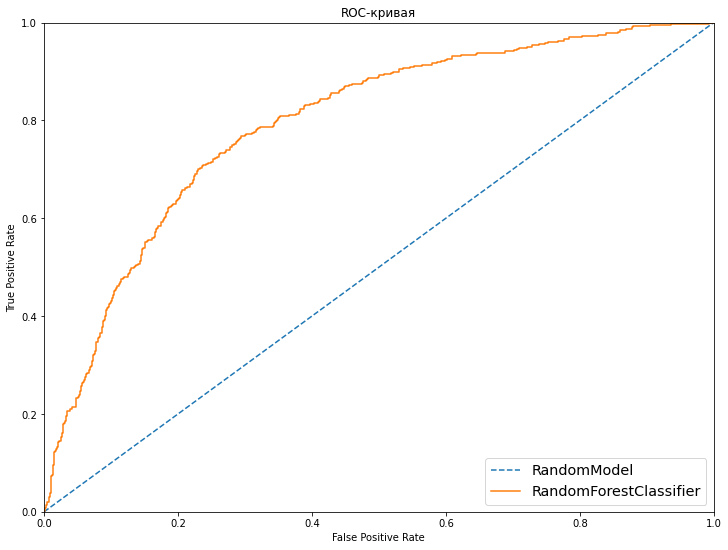

In [ ]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')

model_rf_upsample =  RandomForestClassifier(random_state=12345, n_estimators=42,
                                                   max_depth = 11)
model_rf_upsample.fit(features_upsampled, target_upsampled)
predicted_valid = model_rf_upsample.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

## Тестирование модели

In [ ]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [ ]:
model = RandomForestClassifier(random_state=12345, n_estimators=42,
                                                   max_depth = 11)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
f1_score(target_test, predicted_test)

0.5974625144175317

**Вывод**

1. Изучил и подготовил данные. Заполнил пропуски, изменил названия столбцов, привел к нужному типу данныых. Два класса целевой переменной оказались не сбалансированы (соотношение 20 на 80).
2. Разбил данные на тренировочную, валидационную и тестовую выборки.
3. Проверил модели на данных без балансировки целевой переменной.
4. Сбалансировал классы разынми способами и протестил на моделях.
5. Получил улучшенную модель. Выделил гиперпараметры с лучшей f1-мерой.
6. Провёл тест на тестовой выборке, получил результат f1-меры больше 0,59.

Обученная модель случайного леса с увеличением выборки имеет достаточную адекватность, подтвержденная ее значением AUC-ROC более 0.79. Это лучше, чем случайная модель предсказывания (AUC-ROC = 0.5). На тестовой выборке показала значение F-меры - 0.59, что соответствует требованиям проекта.